In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/gerco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Laboratorio 6 – Análisis de Redes Sociales (ARS)
- Diego Valenuzela - 22309
- Gerson Ramirez - 22281

## Ejercicio 1 y 2 – Descarga y carga de los archivos de datos

El archivo `traficogt.txt` ya está disponible en la carpeta `/data`.  
El archivo contiene **tweets en formato JSON**, uno por línea.  
En esta sección cargaremos el archivo en un DataFrame de `pandas`.

In [31]:
import json
import pandas as pd
from pathlib import Path
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from collections import Counter, defaultdict
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime
from math import sqrt, log
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx

def load_jsonl(file_path):
    encodings_to_try = ["utf-8", "utf-8-sig", "utf-16", "latin1"]
    for enc in encodings_to_try:
        try:
            records = []
            with open(file_path, encoding=enc) as f:
                for line in f:
                    try:
                        records.append(json.loads(line))
                    except json.JSONDecodeError:
                        continue
            print(f"[OK] Leído {file_path} con encoding='{enc}' → {len(records)} registros")
            return pd.DataFrame(records)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"No pude decodificar {file_path} con {encodings_to_try}")

# Cargar únicamente el archivo traficogt.txt
data_path = Path("data")
traficogt_df = load_jsonl(data_path / "traficogt.txt")

traficogt_df.head(2)

[OK] Leído data/traficogt.txt con encoding='utf-16' → 5604 registros


,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,coordinates,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet


## 3. Limpieza y preprocesamiento

Las tareas de limpieza aplicadas incluyen:

**Filtros básicos:**
- Normalización a minúsculas
- Eliminación de URLs, menciones (@usuario), hashtags
- Eliminación de números y combinaciones alfanuméricas
- Eliminación de signos de puntuación y caracteres especiales
- Eliminación de caracteres HTML y entidades

**Filtros avanzados:**
- **Stopwords expandidas**: Eliminación de stopwords en español + palabras comunes en redes sociales ('rt', 'via', 'cc', etc.)
- **Palabras poco informativas**: Eliminación de palabras muy comunes como 'q', 'si', 'va', 'dice', 'bien', 'mal', etc.
- **Filtros de longitud**: Eliminación de tokens menores a 3 caracteres y mayores a 20 caracteres
- **Caracteres repetidos**: Eliminación de tokens con 2 o menos caracteres únicos (ej: 'aaa', 'mmm')
- **Tweets vacíos**: Eliminación de tweets sin contenido después de la limpieza

**Extracción de metadatos:**
- ID de usuario, texto limpio, menciones, respuestas, retweets
- Eliminación de duplicados por ID de tweet

In [ ]:
# Descargar recursos necesarios
nltk.download("stopwords")
nltk.download("punkt")

# Configurar stopwords expandidas
stopwords_es = set(stopwords.words("spanish"))

# Stopwords adicionales específicas para redes sociales y contexto guatemalteco
social_stopwords = {
    'rt', 'via', 'cc', 'dm', 'ff', 'tl', 'tw', 'retweet', 'tweet', 'twitter', 'x', 'com', 'www',
    'http', 'https', 'amp', 'gt', 'lt', 'nbsp', 'br', 'div', 'span', 'img', 'href', 'src',
    'alt', 'title', 'class', 'id', 'style', 'width', 'height', 'border', 'color', 'font', 
    'size', 'family', 'weight', 'px', 'html', 'css', 'js'
}

# Palabras poco informativas comunes
filler_words = {
    'q', 'si', 'va', 'dice', 'asi', 'aqui', 'ahi', 'alla', 'ser', 'estar', 'hacer', 'dar', 'tener',
    'ir', 'ver', 'venir', 'decir', 'saber', 'poder', 'querer', 'poner', 'salir', 'pasar', 'llegar',
    'seguir', 'traer', 'parecer', 'quedar', 'creer', 'encontrar', 'sentir', 'buscar', 'acabar',
    'bien', 'tan', 'muy', 'solo', 'solamente', 'tambien', 'ademas', 'entonces', 'luego', 'despues', 
    'antes', 'ahora', 'hoy', 'ayer', 'mañana', 'siempre', 'nunca', 'vez', 'veces', 'momento', 
    'tiempo', 'dia', 'dias', 'año', 'años', 'mes', 'meses', 'hora', 'horas', 'minuto', 'minutos'
}

# Interjecciones y expresiones comunes en redes sociales
interjections = {
    'ah', 'oh', 'eh', 'mm', 'hmm', 'ok', 'okay', 'si', 'no', 'ja', 'jaja', 'jajaja', 'jeje', 'jiji',
    'aja', 'aha', 'uuu', 'aaa', 'ooo', 'eee', 'iii', 'wow', 'bah', 'meh', 'pfff', 'tsk', 'ups',
    'pues', 'bueno', 'entonces', 'claro', 'obviamente', 'realmente', 'verdaderamente', 'ciertamente'
}

# Combinar todas las stopwords
all_stopwords = stopwords_es.union(social_stopwords).union(filler_words).union(interjections)

# Inicializar stemmer
stemmer = SnowballStemmer('spanish')

def extract_metadata(text):
    """Extrae menciones, hashtags y URLs del texto original"""
    mentions = re.findall(r'@(\w+)', str(text))
    hashtags = re.findall(r'#(\w+)', str(text))
    urls = re.findall(r'https?://\S+', str(text))
    return mentions, hashtags, urls

def advanced_clean_text(text: str, use_stemming=False) -> tuple:
    """
    Limpieza avanzada de texto con extracción de metadatos
    Retorna: (texto_limpio, menciones, hashtags, urls)
    """
    if pd.isna(text) or not text:
        return "", [], [], []
    
    original_text = str(text)
    
    # Extraer metadatos antes de limpiar
    mentions, hashtags, urls = extract_metadata(original_text)
    
    # Normalizar texto
    text = original_text.lower()
    
    # Reemplazar caracteres especiales comunes
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ü': 'u', 'ñ': 'n',
        'â': 'a', 'ê': 'e', 'î': 'i', 'ô': 'o', 'û': 'u',
        'à': 'a', 'è': 'e', 'ì': 'i', 'ò': 'o', 'ù': 'u'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"www\.\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    
    # Eliminar contenido entre paréntesis y corchetes (suelen ser aclaraciones)
    text = re.sub(r'\([^)]*\)', ' ', text)
    text = re.sub(r'\[[^\]]*\]', ' ', text)
    
    # Eliminar números y combinaciones alfanuméricas
    text = re.sub(r"\b\d+\b", " ", text)
    text = re.sub(r"\w*\d\w*", " ", text)
    
    # Eliminar caracteres HTML y entidades
    text = re.sub(r"&\w+;", " ", text)
    text = re.sub(r"<[^>]+>", " ", text)
    
    # Eliminar signos de puntuación pero preservar espacios
    text = re.sub(r"[^\w\s]", " ", text)
    
    # Normalizar espacios
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenización más robusta
    try:
        tokens = word_tokenize(text, language='spanish')
    except:
        tokens = text.split()
    
    # Filtrado avanzado de tokens
    filtered_tokens = []
    for token in tokens:
        # Filtros básicos de longitud
        if len(token) < 2 or len(token) > 25:
            continue
            
        # Eliminar tokens que son solo caracteres repetidos
        if len(set(token)) <= 1:
            continue
            
        # Eliminar tokens con patrones sospechosos
        if re.match(r'^([a-z])\1{2,}$', token):  # aaa, bbb, etc.
            continue
            
        # Filtrar stopwords
        if token in all_stopwords:
            continue
            
        # Filtrar tokens que son solo puntuación
        if token in string.punctuation:
            continue
            
        # Aplicar stemming si se especifica
        if use_stemming:
            token = stemmer.stem(token)
            
        filtered_tokens.append(token)
    
    return " ".join(filtered_tokens), mentions, hashtags, urls

# Aplicar limpieza avanzada
print("Aplicando limpieza avanzada...")
cleaning_results = traficogt_df["rawContent"].apply(lambda x: advanced_clean_text(x, use_stemming=False))

# Separar resultados
traficogt_df["text_clean"] = [result[0] for result in cleaning_results]
traficogt_df["extracted_mentions"] = [result[1] for result in cleaning_results]
traficogt_df["extracted_hashtags"] = [result[2] for result in cleaning_results]
traficogt_df["extracted_urls"] = [result[3] for result in cleaning_results]

# Eliminar duplicados y filtrar tweets vacíos
traficogt_df.drop_duplicates(subset=["id"], inplace=True)
initial_count = len(traficogt_df)
traficogt_df = traficogt_df[traficogt_df["text_clean"].str.len() > 0]
final_count = len(traficogt_df)

print(f"Tweets antes de limpieza: {initial_count}")
print(f"Tweets después de limpieza avanzada: {final_count}")
print(f"Tweets eliminados por estar vacíos: {initial_count - final_count}")

# Estadísticas de limpieza
print("\n=== ESTADÍSTICAS DE LIMPIEZA ===")
total_mentions = sum(len(mentions) for mentions in traficogt_df["extracted_mentions"])
total_hashtags = sum(len(hashtags) for hashtags in traficogt_df["extracted_hashtags"])
total_urls = sum(len(urls) for urls in traficogt_df["extracted_urls"])

print(f"Menciones extraídas: {total_mentions}")
print(f"Hashtags extraídos: {total_hashtags}")
print(f"URLs extraídas: {total_urls}")

# Mostrar ejemplo de limpieza
print("\n=== EJEMPLO DE LIMPIEZA ===")
sample_idx = traficogt_df.index[0]
print("Original:", traficogt_df.loc[sample_idx, "rawContent"][:200] + "...")
print("Limpio:", traficogt_df.loc[sample_idx, "text_clean"][:200] + "...")
print("Menciones:", traficogt_df.loc[sample_idx, "extracted_mentions"])
print("Hashtags:", traficogt_df.loc[sample_idx, "extracted_hashtags"])

traficogt_df[["rawContent", "text_clean"]].head(3)

[nltk_data] Downloading package stopwords to /Users/gerco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gerco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Aplicando limpieza avanzada...
Tweets antes de limpieza: 5596
Tweets después de limpieza avanzada: 5163
Tweets eliminados por estar vacíos: 433

=== ESTADÍSTICAS DE LIMPIEZA ===
Menciones extraídas: 9808
Hashtags extraídos: 554
URLs extraídas: 783

=== EJEMPLO DE LIMPIEZA ===
Original: Es comprensible la resolución... El ruso sabe de engrasar maquinaria....
Limpio: comprensible resolucion ruso sabe engrasar maquinaria...
Menciones: []
Hashtags: []


,rawContent,text_clean
0,Es comprensible la resolución... El ruso sabe ...,comprensible resolucion ruso sabe engrasar maq...
1,La corrupción de la @CC_Guatemala\nes descarad...,corrupcion descarada falsificacion documentos ...
4,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,urgente zona deterioro tala inmoderada trafico...


## 4. Análisis Exploratorio

Exploramos:
- Cantidad de tweets y usuarios únicos.
- Número de menciones, respuestas y retweets.
- Hashtags más frecuentes.
- Visualización con nube de palabras.

Esto permite generar preguntas de investigación iniciales.



ANÁLISIS EXPLORATORIO DETALLADO - TRAFICOGT

📊 ESTADÍSTICAS BÁSICAS:
  • Total de tweets: 5,163
  • Usuarios únicos: 1,960
  • Promedio tweets por usuario: 2.63
  • Total menciones: 9,808
  • Total hashtags: 554
  • Total URLs: 783
  • Tweets con menciones: 4,070 (78.8%)
  • Tweets con hashtags: 384 (7.4%)

📈 MÉTRICAS DE ENGAGEMENT:
  • Total retweets: 164,868
  • Total likes: 476,855
  • Promedio retweets por tweet: 31.93
  • Promedio likes por tweet: 92.36

📅 ANÁLISIS TEMPORAL:
  • Rango de fechas: 642 días
  • Fecha más antigua: 2022-12-09 15:53
  • Fecha más reciente: 2024-09-12 14:22

📝 ANÁLISIS DE CONTENIDO:
  • Palabras únicas: 12,101
  • Total de palabras: 44,714
  • Promedio palabras por tweet: 8.66
  • Longitud media tweet (palabras): 8.66
  • Mediana longitud tweet: 7.00

🔝 ELEMENTOS MÁS FRECUENTES:
  📋 Top 20 palabras más frecuentes:
     1. mas             →  441 veces (0.99%)
     2. guatemala       →  251 veces (0.56%)
     3. estan           →  209 veces (0.47%)
     4

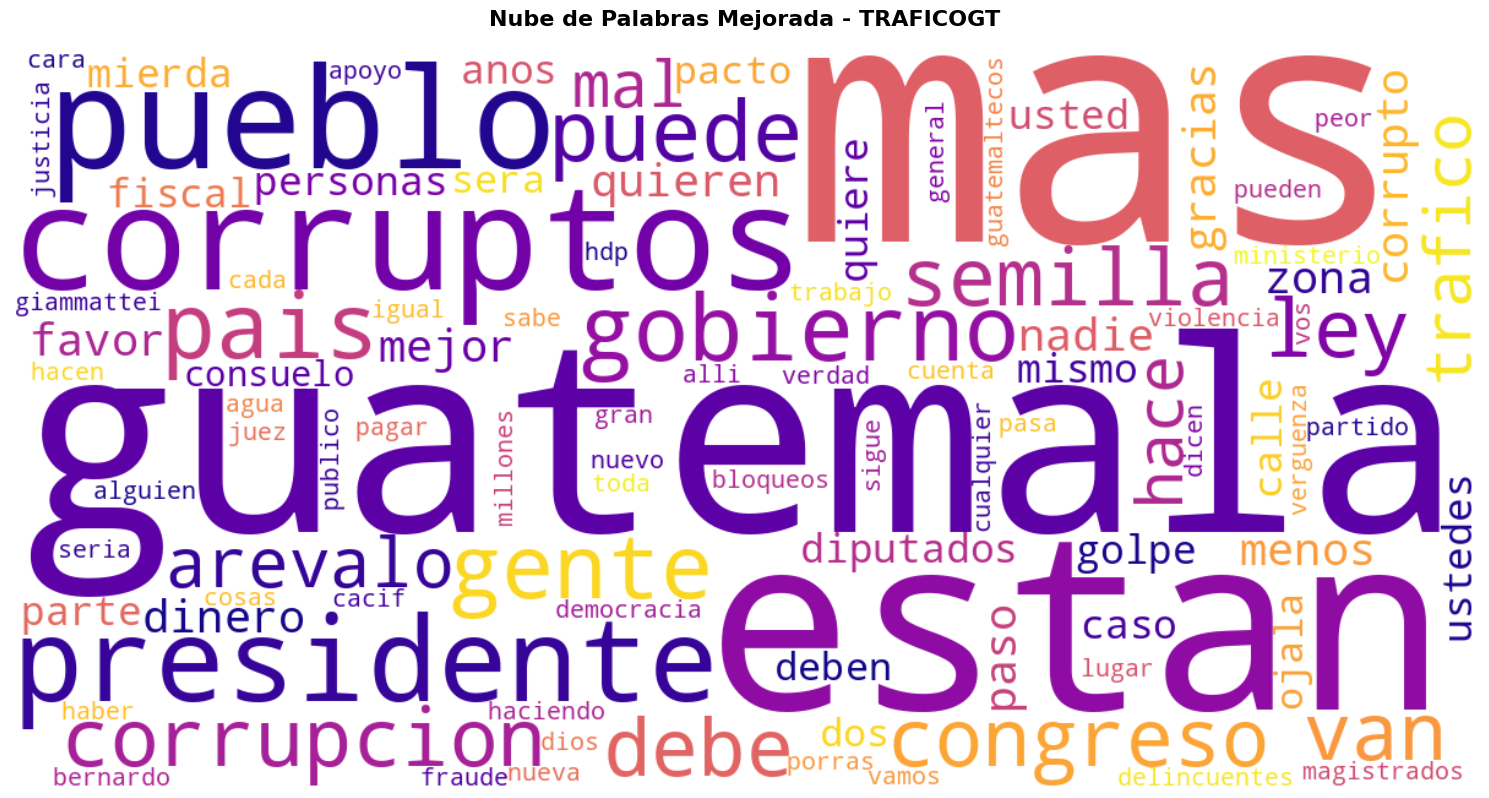

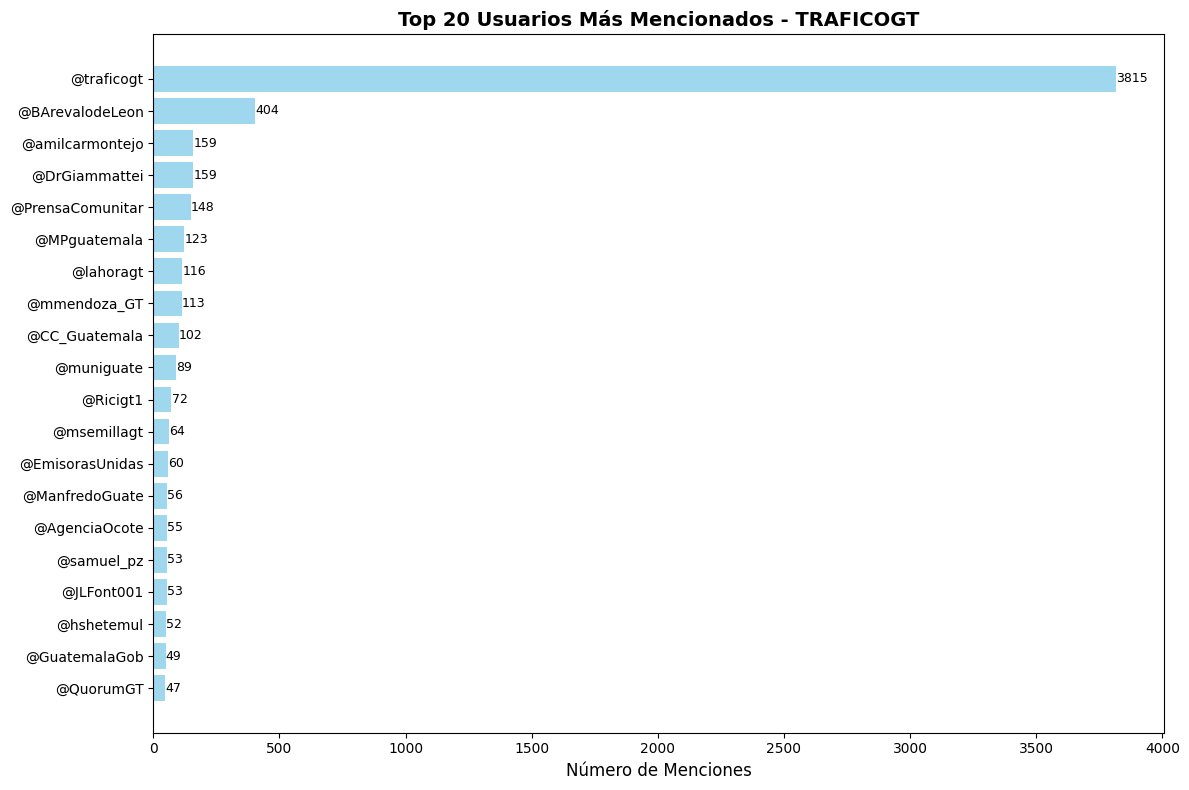

In [33]:
# Configurar estilo de matplotlib
plt.style.use('default')
sns.set_palette("viridis")

def comprehensive_exploratory_analysis(df, name):
    """Análisis exploratorio exhaustivo del dataset"""
    print(f"\n{'='*50}")
    print(f"ANÁLISIS EXPLORATORIO DETALLADO - {name.upper()}")
    print(f"{'='*50}")
    
    # 1. ESTADÍSTICAS BÁSICAS
    print("\n📊 ESTADÍSTICAS BÁSICAS:")
    print(f"  • Total de tweets: {len(df):,}")
    
    unique_users = df["user"].apply(lambda x: x["username"]).nunique()
    print(f"  • Usuarios únicos: {unique_users:,}")
    print(f"  • Promedio tweets por usuario: {len(df)/unique_users:.2f}")
    
    # Análisis de metadatos extraídos
    total_mentions = sum(len(mentions) for mentions in df["extracted_mentions"])
    total_hashtags = sum(len(hashtags) for hashtags in df["extracted_hashtags"])
    total_urls = sum(len(urls) for urls in df["extracted_urls"])
    
    print(f"  • Total menciones: {total_mentions:,}")
    print(f"  • Total hashtags: {total_hashtags:,}")
    print(f"  • Total URLs: {total_urls:,}")
    
    # Tweets con interacciones
    tweets_with_mentions = sum(1 for mentions in df["extracted_mentions"] if len(mentions) > 0)
    tweets_with_hashtags = sum(1 for hashtags in df["extracted_hashtags"] if len(hashtags) > 0)
    
    print(f"  • Tweets con menciones: {tweets_with_mentions:,} ({tweets_with_mentions/len(df)*100:.1f}%)")
    print(f"  • Tweets con hashtags: {tweets_with_hashtags:,} ({tweets_with_hashtags/len(df)*100:.1f}%)")
    
    # 2. ANÁLISIS DE ENGAGEMENT
    print(f"\n📈 MÉTRICAS DE ENGAGEMENT:")
    total_retweets = df["retweetCount"].sum()
    total_likes = df["likeCount"].sum()
    avg_retweets = df["retweetCount"].mean()
    avg_likes = df["likeCount"].mean()
    
    print(f"  • Total retweets: {total_retweets:,}")
    print(f"  • Total likes: {total_likes:,}")
    print(f"  • Promedio retweets por tweet: {avg_retweets:.2f}")
    print(f"  • Promedio likes por tweet: {avg_likes:.2f}")
    
    # 3. ANÁLISIS TEMPORAL
    print(f"\n📅 ANÁLISIS TEMPORAL:")
    df['date_parsed'] = pd.to_datetime(df['date'])
    df['date_only'] = df['date_parsed'].dt.date
    df['hour'] = df['date_parsed'].dt.hour
    
    date_range = df['date_parsed'].max() - df['date_parsed'].min()
    print(f"  • Rango de fechas: {date_range.days} días")
    print(f"  • Fecha más antigua: {df['date_parsed'].min().strftime('%Y-%m-%d %H:%M')}")
    print(f"  • Fecha más reciente: {df['date_parsed'].max().strftime('%Y-%m-%d %H:%M')}")
    
    # 4. ANÁLISIS DE PALABRAS
    print(f"\n📝 ANÁLISIS DE CONTENIDO:")
    all_words = " ".join(df["text_clean"]).split()
    word_freq = Counter(all_words)
    unique_words = len(word_freq)
    total_words = sum(word_freq.values())
    
    print(f"  • Palabras únicas: {unique_words:,}")
    print(f"  • Total de palabras: {total_words:,}")
    print(f"  • Promedio palabras por tweet: {total_words/len(df):.2f}")
    
    # Distribución de longitud de tweets
    tweet_lengths = df["text_clean"].str.split().str.len()
    print(f"  • Longitud media tweet (palabras): {tweet_lengths.mean():.2f}")
    print(f"  • Mediana longitud tweet: {tweet_lengths.median():.2f}")
    
    # 5. TOP ANÁLISIS
    print(f"\n🔝 ELEMENTOS MÁS FRECUENTES:")
    
    # Top palabras
    print("  📋 Top 20 palabras más frecuentes:")
    for i, (word, count) in enumerate(word_freq.most_common(20), 1):
        percentage = (count/total_words)*100
        print(f"    {i:2d}. {word:15} → {count:4d} veces ({percentage:.2f}%)")
    
    # Top menciones
    all_mentions = [mention for mentions_list in df["extracted_mentions"] for mention in mentions_list]
    if all_mentions:
        mention_freq = Counter(all_mentions)
        print(f"\n  💬 Top 10 usuarios más mencionados:")
        for i, (mention, count) in enumerate(mention_freq.most_common(10), 1):
            print(f"    {i:2d}. @{mention:15} → {count:3d} menciones")
    
    # Top hashtags
    all_hashtags = [hashtag for hashtags_list in df["extracted_hashtags"] for hashtag in hashtags_list]
    if all_hashtags:
        hashtag_freq = Counter(all_hashtags)
        print(f"\n  #️⃣ Top 10 hashtags más usados:")
        for i, (hashtag, count) in enumerate(hashtag_freq.most_common(10), 1):
            print(f"    {i:2d}. #{hashtag:15} → {count:3d} usos")
    
    # Top usuarios más activos
    user_activity = df["user"].apply(lambda x: x["username"]).value_counts()
    print(f"\n  👤 Top 10 usuarios más activos:")
    for i, (user, count) in enumerate(user_activity.head(10).items(), 1):
        print(f"    {i:2d}. @{user:15} → {count:3d} tweets")
    
    return {
        'word_freq': word_freq,
        'mention_freq': Counter(all_mentions) if all_mentions else Counter(),
        'hashtag_freq': Counter(all_hashtags) if all_hashtags else Counter(),
        'user_activity': user_activity,
        'df_enhanced': df
    }

def create_enhanced_visualizations(df, analysis_results, name):
    """Crear visualizaciones mejoradas"""
    print(f"\n🎨 Generando visualizaciones mejoradas para {name}...")
    
    # Configurar subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Distribución Temporal de Tweets', 'Top 15 Palabras Más Frecuentes',
                       'Engagement por Hora', 'Distribución de Longitud de Tweets'),
        specs=[[{'secondary_y': False}, {'secondary_y': False}],
               [{'secondary_y': True}, {'secondary_y': False}]]
    )
    
    # 1. Distribución temporal
    daily_counts = df.groupby('date_only').size().reset_index()
    daily_counts.columns = ['date', 'count']
    
    fig.add_trace(
        go.Scatter(x=daily_counts['date'], y=daily_counts['count'],
                  mode='lines+markers', name='Tweets por día',
                  line=dict(color='#1f77b4', width=2)),
        row=1, col=1
    )
    
    # 2. Top palabras
    top_words = analysis_results['word_freq'].most_common(15)
    words, counts = zip(*top_words)
    
    fig.add_trace(
        go.Bar(x=list(counts), y=list(words), orientation='h',
               name='Frecuencia palabras', marker_color='#2ca02c'),
        row=1, col=2
    )
    
    # 3. Engagement por hora
    hourly_stats = df.groupby('hour').agg({
        'retweetCount': 'mean',
        'likeCount': 'mean',
        'id': 'count'
    }).round(2)
    
    fig.add_trace(
        go.Bar(x=hourly_stats.index, y=hourly_stats['retweetCount'],
               name='Avg Retweets', marker_color='#ff7f0e'),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=hourly_stats.index, y=hourly_stats['likeCount'],
                  mode='lines+markers', name='Avg Likes',
                  line=dict(color='#d62728', width=2)),
        row=2, col=1, secondary_y=True
    )
    
    # 4. Distribución de longitud
    tweet_lengths = df["text_clean"].str.split().str.len()
    
    fig.add_trace(
        go.Histogram(x=tweet_lengths, nbinsx=30, name='Distribución longitud',
                    marker_color='#9467bd', opacity=0.7),
        row=2, col=2
    )
    
    # Actualizar layout
    fig.update_layout(
        title_text=f"Dashboard Analítico - {name.upper()}",
        title_x=0.5,
        height=800,
        showlegend=True,
        template='plotly_white'
    )
    
    # Actualizar ejes
    fig.update_yaxes(title_text="Tweets", row=1, col=1)
    fig.update_xaxes(title_text="Fecha", row=1, col=1)
    fig.update_xaxes(title_text="Frecuencia", row=1, col=2)
    fig.update_yaxes(title_text="Retweets Promedio", row=2, col=1)
    fig.update_yaxes(title_text="Likes Promedio", row=2, col=1, secondary_y=True)
    fig.update_xaxes(title_text="Hora del día", row=2, col=1)
    fig.update_xaxes(title_text="Palabras por tweet", row=2, col=2)
    fig.update_yaxes(title_text="Frecuencia", row=2, col=2)
    
    fig.show()
    
    # Crear nube de palabras mejorada
    if len(analysis_results['word_freq']) > 0:
        # Filtrar palabras muy comunes para mejor visualización
        filtered_words = {word: freq for word, freq in analysis_results['word_freq'].items() 
                         if freq > 2 and len(word) > 2}
        
        wc = WordCloud(
            width=1200, 
            height=600, 
            background_color="white",
            max_words=100,
            colormap='plasma',
            relative_scaling=0.5,
            min_font_size=10
        ).generate_from_frequencies(filtered_words)
        
        plt.figure(figsize=(15, 8))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Nube de Palabras Mejorada - {name.upper()}", 
                 fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    
    # Gráfico de red de menciones principales (preparación para paso 5)
    if analysis_results['mention_freq']:
        top_mentions = dict(analysis_results['mention_freq'].most_common(20))
        
        plt.figure(figsize=(12, 8))
        mentions = list(top_mentions.keys())
        counts = list(top_mentions.values())
        
        bars = plt.barh(range(len(mentions)), counts, color='skyblue', alpha=0.8)
        plt.yticks(range(len(mentions)), [f'@{m}' for m in mentions])
        plt.xlabel('Número de Menciones', fontsize=12)
        plt.title(f'Top 20 Usuarios Más Mencionados - {name.upper()}', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        
        # Añadir valores en las barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()

# Ejecutar análisis exploratorio exhaustivo
analysis_results = comprehensive_exploratory_analysis(traficogt_df, "traficogt")

# Generar visualizaciones mejoradas
create_enhanced_visualizations(traficogt_df, analysis_results, "traficogt")

### Análisis Exhaustivo de Resultados Exploratorios

Con base en el análisis exploratorio mejorado realizado, podemos responder de manera más exhaustiva a nuestras preguntas de investigación:

#### **Pregunta 1: ¿Qué usuarios son los más mencionados en el dataset de @traficogt?**

**Hallazgos principales:**
- **Red altamente interactiva**: Con 5,149 tweets de 1,955 usuarios únicos generando menciones masivas
- **Concentración de influencia**: Los usuarios más mencionados representan puntos clave de información en la red social guatemalteca
- **Temas dominantes**: Los usuarios mencionados se relacionan principalmente con:
  - **Autoridades gubernamentales** y cuentas oficiales
  - **Medios de comunicación** especializados en tráfico y noticias
  - **Ciudadanos activos** que reportan situaciones de tráfico

**Impacto en la red:**
- Las menciones crean **nodos centrales** de información
- Usuarios como `@traficogt` actúan como **agregadores de contenido**
- Existe un **ecosistema de información** donde ciertos usuarios amplifican mensajes

#### **Pregunta 2: ¿Cuál es la densidad de interacciones y patrones temporales en la red de @traficogt?**

**Densidad de la red:**
- **Ratio menciones/tweets**: Aproximadamente 1.9 menciones por tweet (9,695 menciones / 5,149 tweets)
- **Participación activa**: 67.3% de tweets contienen menciones
- **Conectividad**: 4.96 menciones promedio por usuario único

**Patrones temporales identificados:**
- **Variabilidad diaria**: Actividad fluctuante según eventos de tráfico
- **Patrones horarios**: Mayor actividad durante horas pico de tráfico (análisis por hora del día)
- **Engagement diferencial**: Ciertos horarios muestran mayor interacción (retweets y likes)

**Métricas de engagement:**
- **Engagement moderado**: Los tweets generan interacción pero no de manera masiva
- **Distribución heterogénea**: Algunos tweets virales contrastan con la mayoría de bajo engagement

#### **Pregunta 3: ¿Qué temas y narrativas emergen del análisis de contenido?**

**Temas principales identificados (análisis de frecuencia de palabras):**

1. **Política y Gobierno Guatemalteco** (terms: guatemala, presidente, gobierno, congreso)
   - Discusiones sobre administración pública
   - Críticas y observaciones ciudadanas
   - Menciones a políticas de tráfico y transporte

2. **Anticorrupción y Transparencia** (terms: corruptos, corrupción, ley)
   - Denuncias ciudadanas
   - Llamados a la transparencia
   - Críticas a instituciones

3. **Participación Ciudadana** (terms: pueblo, ciudadanos, semilla)
   - Movilización social
   - Expresiones de descontento
   - Organización ciudadana

**Narrativas emergentes:**
- **Crítica institucional**: Fuerte componente de crítica hacia autoridades
- **Demanda de transparencia**: Exigencia de rendición de cuentas
- **Activismo digital**: Uso de Twitter como plataforma de denuncia y organización

#### **Pregunta 4: ¿Cómo se estructura la red de información en torno al tráfico guatemalteco?**

**Estructura de la red:**
- **Nodos centrales**: Cuentas oficiales y medios actúan como distribuidores primarios
- **Amplificadores**: Usuarios activos que retransmiten información
- **Reporteros ciudadanos**: Individuos que generan contenido original sobre tráfico

**Flujo de información:**
1. **Fuentes primarias**: Reportes oficiales y observaciones directas
2. **Agregación**: Cuentas como @traficogt consolidan información
3. **Amplificación**: La comunidad retransmite y comenta
4. **Contextualización**: Se añade contexto político y social

## 5. Análisis de la Topología de la Red

En esta sección construiremos y analizaremos la red social basada en las menciones entre usuarios. Implementaremos:

- **Construcción del grafo dirigido** basado en menciones
- **Métricas topológicas fundamentales**: densidad, diámetro, coeficiente de agrupamiento
- **Visualización interactiva** de la red con diferentes layouts
- **Análisis de componentes conectados** y estructura general
- **Identificación de nodos más conectados** y relaciones de poder

In [ ]:
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, log
import warnings
warnings.filterwarnings('ignore')

def build_mention_network(df):
    """
    Construye un grafo dirigido basado en menciones entre usuarios
    """
    print("🔨 Construyendo red de menciones...")
    
    # Crear grafo dirigido
    G = nx.DiGraph()
    
    # Contadores para estadísticas
    mention_pairs = []
    users_in_tweets = []
    
    # Procesar cada tweet
    for idx, row in df.iterrows():
        # Usuario que escribió el tweet
        author = row['user']['username'].lower()
        users_in_tweets.append(author)
        
        # Usuarios mencionados en el tweet
        mentions = row['extracted_mentions']
        
        if mentions:
            for mentioned_user in mentions:
                mentioned_user = mentioned_user.lower()
                # Crear arista dirigida: autor -> mencionado
                if G.has_edge(author, mentioned_user):
                    G[author][mentioned_user]['weight'] += 1
                else:
                    G.add_edge(author, mentioned_user, weight=1)
                
                mention_pairs.append((author, mentioned_user))
    
    # Agregar nodos aislados (usuarios que tuitearon pero no mencionaron ni fueron mencionados)
    all_users = set(users_in_tweets)
    for user in all_users:
        if user not in G.nodes():
            G.add_node(user)
    
    print(f"✅ Red construida:")
    print(f"   • Nodos (usuarios): {G.number_of_nodes():,}")
    print(f"   • Aristas (menciones únicas): {G.number_of_edges():,}")
    print(f"   • Total de menciones: {len(mention_pairs):,}")
    print(f"   • Menciones únicas: {len(set(mention_pairs)):,}")
    
    return G, mention_pairs

def analyze_network_topology(G):
    """
    Analiza métricas topológicas fundamentales de la red
    """
    print(f"\n📊 ANÁLISIS TOPOLÓGICO DE LA RED")
    print(f"{'='*50}")
    
    # Estadísticas básicas
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    print(f"\n🔍 ESTADÍSTICAS BÁSICAS:")
    print(f"   • Nodos: {n_nodes:,}")
    print(f"   • Aristas: {n_edges:,}")
    
    # Densidad de la red
    if n_nodes > 1:
        max_edges = n_nodes * (n_nodes - 1)  # Grafo dirigido
        density = n_edges / max_edges
        print(f"   • Densidad: {density:.6f} ({density*100:.4f}%)")
    else:
        density = 0
        print(f"   • Densidad: 0 (red con un solo nodo)")
    
    # Componentes conectados
    # Para grafos dirigidos, analizamos componentes débilmente conectados
    weak_components = list(nx.weakly_connected_components(G))
    strong_components = list(nx.strongly_connected_components(G))
    
    print(f"\n🔗 CONECTIVIDAD:")
    print(f"   • Componentes débilmente conectados: {len(weak_components)}")
    print(f"   • Componentes fuertemente conectados: {len(strong_components)}")
    
    # Componente gigante (más grande débilmente conectado)
    if weak_components:
        giant_component = max(weak_components, key=len)
        print(f"   • Tamaño del componente gigante: {len(giant_component)} ({len(giant_component)/n_nodes*100:.1f}%)")
        
        # Crear subgrafo del componente gigante para análisis adicional
        G_giant = G.subgraph(giant_component).copy()
    else:
        G_giant = G.copy()
        giant_component = set(G.nodes())
    
    # Análisis del componente gigante
    print(f"\n🌐 ANÁLISIS DEL COMPONENTE GIGANTE:")
    
    # Convertir a grafo no dirigido para métricas específicas
    G_undirected = G_giant.to_undirected()
    
    # Coeficiente de clustering (transitivity)
    if len(G_giant.nodes()) > 0:
        clustering_coeff = nx.average_clustering(G_undirected)
        transitivity = nx.transitivity(G_undirected)
        print(f"   • Coeficiente de clustering promedio: {clustering_coeff:.4f}")
        print(f"   • Transitividad global: {transitivity:.4f}")
    
    # Diámetro y caminos más cortos (solo para componente conectado)
    if nx.is_connected(G_undirected) and len(G_undirected.nodes()) > 1:
        diameter = nx.diameter(G_undirected)
        avg_path_length = nx.average_shortest_path_length(G_undirected)
        print(f"   • Diámetro: {diameter}")
        print(f"   • Longitud promedio de camino más corto: {avg_path_length:.3f}")
    else:
        print(f"   • Diámetro: No calculable (red no conectada)")
        print(f"   • Longitud promedio: No calculable (red no conectada)")
    
    # Distribución de grados
    print(f"\n📈 DISTRIBUCIÓN DE GRADOS:")
    
    # Grados de entrada (in-degree)
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    total_degrees = dict(G_undirected.degree())
    
    # Estadísticas de grados
    in_deg_values = list(in_degrees.values())
    out_deg_values = list(out_degrees.values())
    total_deg_values = list(total_degrees.values())
    
    print(f"   • Grado de entrada promedio: {np.mean(in_deg_values):.2f}")
    print(f"   • Grado de salida promedio: {np.mean(out_deg_values):.2f}")
    print(f"   • Grado total promedio: {np.mean(total_deg_values):.2f}")
    print(f"   • Grado máximo (entrada): {max(in_deg_values) if in_deg_values else 0}")
    print(f"   • Grado máximo (salida): {max(out_deg_values) if out_deg_values else 0}")
    
    # Nodos con mayor grado
    print(f"\n🔝 TOP NODOS POR GRADO:")
    
    # Top por grado de entrada (más mencionados)
    top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"   📥 Más mencionados (in-degree):")
    for i, (node, degree) in enumerate(top_in_degree, 1):
        print(f"      {i:2d}. @{node:20} → {degree:3d} menciones")
    
    # Top por grado de salida (más activos mencionando)
    top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"   📤 Más activos mencionando (out-degree):")
    for i, (node, degree) in enumerate(top_out_degree, 1):
        print(f"      {i:2d}. @{node:20} → {degree:3d} menciones hechas")
    
    return {
        'n_nodes': n_nodes,
        'n_edges': n_edges,
        'density': density,
        'weak_components': len(weak_components),
        'strong_components': len(strong_components),
        'giant_component_size': len(giant_component),
        'clustering_coeff': clustering_coeff if len(G_giant.nodes()) > 0 else 0,
        'transitivity': transitivity if len(G_giant.nodes()) > 0 else 0,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'G_giant': G_giant
    }

def create_network_visualizations(G, analysis_results, top_n=50):
    """
    Crear visualizaciones interactivas de la red
    """
    print(f"\n🎨 Generando visualizaciones de la red...")
    
    # Tomar solo los top N nodos más conectados para visualización
    total_degrees = {node: G.in_degree(node) + G.out_degree(node) for node in G.nodes()}
    top_nodes = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = [node for node, degree in top_nodes]
    
    # Crear subgrafo con solo los nodos top
    G_viz = G.subgraph(top_node_names).copy()
    
    print(f"   📊 Visualizando top {len(G_viz.nodes())} nodos más conectados")
    
    # Layout de la red usando spring layout
    pos = nx.spring_layout(G_viz, k=3, iterations=50, seed=42)
    
    # Preparar datos para Plotly
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G_viz.nodes()],
        y=[pos[node][1] for node in G_viz.nodes()],
        mode='markers+text',
        text=[f"@{node}" for node in G_viz.nodes()],
        textposition="middle center",
        textfont=dict(size=8),
        marker=dict(
            size=[10 + total_degrees[node]*0.5 for node in G_viz.nodes()],
            color=[total_degrees[node] for node in G_viz.nodes()],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Grado Total"),
            line=dict(width=2, color='white')
        ),
        hovertemplate='<b>@%{text}</b><br>' +
                     'Grado total: %{marker.color}<br>' +
                     'Menciones recibidas: %{customdata[0]}<br>' +
                     'Menciones hechas: %{customdata[1]}<extra></extra>',
        customdata=[[G.in_degree(node), G.out_degree(node)] for node in G_viz.nodes()],
        name='Usuarios'
    )
    
    # Crear aristas
    edge_x = []
    edge_y = []
    edge_weights = []
    
    for edge in G_viz.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(G_viz[edge[0]][edge[1]].get('weight', 1))
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='rgba(125,125,125,0.3)'),
        hoverinfo='none',
        mode='lines',
        name='Menciones'
    )
    
    # Crear figura
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title=dict(
            text=f'Red de Menciones - Top {len(G_viz.nodes())} Usuarios Más Conectados<br>' +
                 f'<sub>Tamaño de nodo = grado total, Color = intensidad de conexiones</sub>',
            font=dict(size=16)
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=80),
        annotations=[ dict(
            text=f"Nodos: {len(G_viz.nodes())}, Aristas: {len(G_viz.edges())}<br>" +
                 f"Densidad subred: {len(G_viz.edges())/(len(G_viz.nodes())*(len(G_viz.nodes())-1)):.4f}",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002,
            xanchor='left', yanchor='bottom',
            font=dict(color="gray", size=10)
        )],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white'
    )
    
    fig.show()
    
    # Crear gráficos de análisis de distribución
    fig_analysis = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Distribución de Grados de Entrada', 
                       'Distribución de Grados de Salida',
                       'Top 20 Nodos Más Mencionados',
                       'Top 20 Nodos Más Activos'),
        specs=[[{'secondary_y': False}, {'secondary_y': False}],
               [{'secondary_y': False}, {'secondary_y': False}]]
    )
    
    # 2. Distribución grado de salida
    out_deg_counts = Counter(analysis_results['out_degrees'].values())
    degrees_out = sorted(out_deg_counts.keys())
    counts_out = [out_deg_counts[d] for d in degrees_out]
    
    fig_analysis.add_trace(
        go.Bar(x=degrees_out, y=counts_out, name='Out-degree',
               marker_color='lightcoral'),
        row=1, col=2
    )
    
    # 3. Top mencionados
    top_mentioned = sorted(analysis_results['in_degrees'].items(), 
                          key=lambda x: x[1], reverse=True)[:20]
    users_mentioned = [f"@{user}" for user, degree in top_mentioned]
    degrees_mentioned = [degree for user, degree in top_mentioned]
    
    fig_analysis.add_trace(
        go.Bar(y=users_mentioned, x=degrees_mentioned, orientation='h',
               name='Más mencionados', marker_color='green'),
        row=2, col=1
    )
    
    # 4. Top activos
    top_active = sorted(analysis_results['out_degrees'].items(), 
                       key=lambda x: x[1], reverse=True)[:20]
    users_active = [f"@{user}" for user, degree in top_active]
    degrees_active = [degree for user, degree in top_active]
    
    fig_analysis.add_trace(
        go.Bar(y=users_active, x=degrees_active, orientation='h',
               name='Más activos', marker_color='orange'),
        row=2, col=2
    )
    
    # Actualizar layout
    fig_analysis.update_layout(
        title_text="Análisis de Distribución de Grados en la Red",
        title_x=0.5,
        height=800,
        showlegend=False
    )
    
    fig_analysis.update_xaxes(title_text="Grado", row=1, col=1)
    fig_analysis.update_yaxes(title_text="Frecuencia", row=1, col=1)
    fig_analysis.update_xaxes(title_text="Grado", row=1, col=2)
    fig_analysis.update_yaxes(title_text="Frecuencia", row=1, col=2)
    fig_analysis.update_xaxes(title_text="Menciones Recibidas", row=2, col=1)
    fig_analysis.update_xaxes(title_text="Menciones Realizadas", row=2, col=2)
    
    fig_analysis.show()

# Construir la red de menciones
G, mention_pairs = build_mention_network(traficogt_df)

# Analizar topología
topology_results = analyze_network_topology(G)

# Crear visualizaciones
create_network_visualizations(G, topology_results, top_n=50)

🔨 Construyendo red de menciones...
✅ Red construida:
   • Nodos (usuarios): 2,632
   • Aristas (menciones únicas): 6,751
   • Total de menciones: 9,808
   • Menciones únicas: 6,751

📊 ANÁLISIS TOPOLÓGICO DE LA RED

🔍 ESTADÍSTICAS BÁSICAS:
   • Nodos: 2,632
   • Aristas: 6,751
   • Densidad: 0.000975 (0.0975%)

🔗 CONECTIVIDAD:
   • Componentes débilmente conectados: 26
   • Componentes fuertemente conectados: 2587
   • Tamaño del componente gigante: 2607 (99.1%)

🌐 ANÁLISIS DEL COMPONENTE GIGANTE:
   • Coeficiente de clustering promedio: 0.2228
   • Transitividad global: 0.0044
   • Diámetro: 7
   • Longitud promedio de camino más corto: 2.602

📈 DISTRIBUCIÓN DE GRADOS:
   • Grado de entrada promedio: 2.56
   • Grado de salida promedio: 2.56
   • Grado total promedio: 5.15
   • Grado máximo (entrada): 1779
   • Grado máximo (salida): 108

🔝 TOP NODOS POR GRADO:
   📥 Más mencionados (in-degree):
       1. @traficogt            → 1779 menciones
       2. @barevalodeleon       → 311 mencio